# **IMPORTADO DE MÓDULOS**

In [ ]:
import numpy as np
import numpy.matlib

import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import tensorflow as tf
tf.version.VERSION

In [ ]:
from scipy.optimize import curve_fit
#https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.losses import mse
import keras.backend as K

In [ ]:
!wget 'http://tomografia.es/data/Co60_5cm_5cm.npy' -q
!wget 'http://tomografia.es/data/Co60_2cm_8cm.npy' -q
!wget 'http://tomografia.es/data/Co60_8cm_2cm.npy' -q

V55= np.load('Co60_5cm_5cm.npy')
V28= np.load('Co60_2cm_8cm.npy')
V82= np.load('Co60_8cm_2cm.npy')

# **PREPROCESSING AND FUNCTIONS**

In [ ]:
start_cfd = 50
stop_cfd = 80

#--------------------------------Interpolar pulsos reales---------------------------------
input = V28[:,start_cfd:stop_cfd,:]
EXTRASAMPLING = 8
Nt = np.shape(input)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func_V28 = interp1d(tiempo,V28[:,start_cfd:stop_cfd,:],  kind='cubic', axis=1)
new_V28 = interp_func_V28(tiempo_new)

interp_func_V55 = interp1d(tiempo,V55[:,start_cfd:stop_cfd,:],  kind='cubic', axis=1)
new_V55 = interp_func_V55(tiempo_new)

interp_func_V82 = interp1d(tiempo,V82[:,start_cfd:stop_cfd,:],  kind='cubic', axis=1)
new_V82 = interp_func_V82(tiempo_new)


print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

Number of time points: 30
Time step: 0.20
New number of time points: 240
New time step: 0.0250


In [ ]:
def find_fraction_index(vector, fraction=0.1):
  new_vector = np.copy(vector)
  energy = np.sum(new_vector, axis = 1)
  cumulative = np.cumsum(new_vector, axis = 1)
  for i in range(new_vector.shape[0]):
    indices = np.where(cumulative[i,:] >= energy[i]*fraction)[0]
    index = indices[0]
    new_vector[i,index:] = 0
  return new_vector


#-----------------------------------------------------------------------------------------------------------

def constant_fraction_discrimination(vector, fraction = 0.1):
    fraction_part = np.zeros_like(vector)
    shifted_fraction_part = np.zeros_like(vector)
    corrected_signal = np.zeros_like(vector)
    for i in range(vector.shape[0]):
      fraction_part[i,:] = vector[i,:] - fraction
      shift  = -np.argmax(fraction_part[i,:])
      shifted_fraction_part[i,:] = np.roll(fraction_part[i,:], shift)
      shifted_fraction_part[i,:shift] =  0 #fraction_part[i,shift:]
      corrected_signal[i,:] = vector[i,:] + shifted_fraction_part[i,:]
      plt.plot(corrected_signal[i,:])
    return corrected_signal

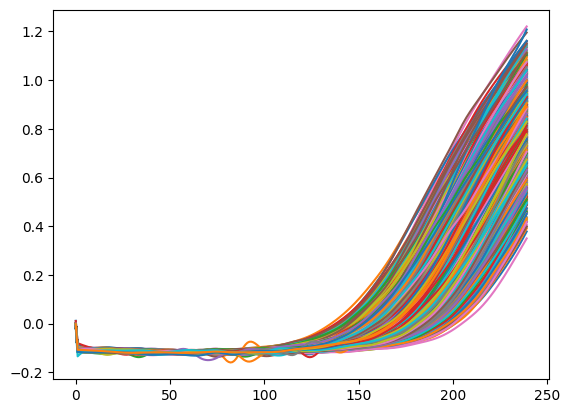

In [ ]:
#new_V28_dec0 = find_fraction_index(new_V28[:,:,0])
#new_V55_dec0 = find_fraction_index(new_V55[:,:,0])
#new_V82_dec0 = find_fraction_index(new_V82[:,:,0])

#new_V28_dec1 = find_fraction_index(new_V28[:,:,1])
#new_V55_dec1 = find_fraction_index(new_V55[:,:,1])
#new_V82_dec1 = find_fraction_index(new_V82[:,:,1])


new_V28_dec0 = constant_fraction_discrimination(new_V28[:,:,0])
new_V55_dec0 = constant_fraction_discrimination(new_V55[:,:,0])
new_V82_dec0 = constant_fraction_discrimination(new_V82[:,:,0])

new_V28_dec1 = constant_fraction_discrimination(new_V28[:,:,1])
new_V55_dec1 = constant_fraction_discrimination(new_V55[:,:,1])
new_V82_dec1 = constant_fraction_discrimination(new_V82[:,:,1])

V28_fraction = np.concatenate((new_V28_dec0[:,:,np.newaxis],new_V28_dec1[:,:,np.newaxis]), axis = 2)
V55_fraction = np.concatenate((new_V55_dec0[:,:,np.newaxis],new_V55_dec1[:,:,np.newaxis]), axis = 2)
V82_fraction = np.concatenate((new_V82_dec0[:,:,np.newaxis],new_V82_dec1[:,:,np.newaxis]), axis = 2)

In [ ]:
def momentos(vector):
  Nev,Nt,Nc = np.shape(vector)    #Nev: Núm eventos, Nt: Núm puntos temporales, Nc: Número canales
  t = np.reshape(np.linspace(0,Nt, Nt)/float(Nt),(1,-1,1))#Normalized array of time
  MOMENT = np.zeros((Nev,0,Nc))

  for i in range(4): #Number of moments used

    W = t**(i+1)
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis= 1)

    W = np.exp(-(i*t))
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis= 1)

    W = np.exp(-(t**(i)))
    W = np.tile(W,(Nev,1,2))
    MM = np.sum(vector*W,axis=1,keepdims=True)
    MOMENT = np.append(MOMENT,MM,axis=1)


  return MOMENT

In [ ]:
INPUT = np.concatenate((V55_fraction,V28_fraction,V82_fraction),axis= 0)
Ncasos = INPUT.shape[0]
Ntrain = int(0.8*Ncasos)

# **DETECTOR 0**

## DATA CREATION


In [ ]:
INPUT2_dec0 = np.zeros_like(INPUT)
REF_dec0 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-3, size=N0)
  noise00 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec0[i,:,0]=np.roll(INPUT[i,:,0],N0)
  INPUT2_dec0[i,:,0] = INPUT2_dec0[i,:,0] + smoothed_noise
  INPUT2_dec0[i,0:N0,0] =  INPUT[i,0:N0,0] + noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-3, size=N1)
  noise11 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec0[i,:,1]=np.roll(INPUT[i,:,0],N1)
  INPUT2_dec0[i,:,1] = INPUT2_dec0[i,:,1] + smoothed_noise
  INPUT2_dec0[i,0:N1,1] = INPUT[i,0:N1,0] + noise1

  REF_dec0[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)


trainX_dec0 = INPUT2_dec0[0:Ntrain,:,:]
valX_dec0 = INPUT2_dec0[Ntrain:,:,:]

REF_train_dec0 = REF_dec0[0:Ntrain]
REF_val_dec0 = REF_dec0[Ntrain:]

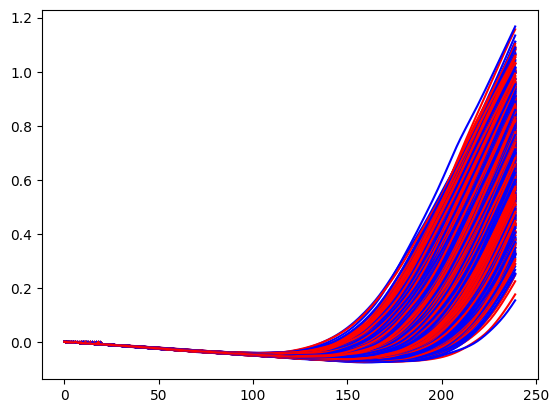

In [ ]:
t = np.arange(Nt_new) / float(Nt_new)
for i in range(trainX_dec0.shape[0]):
  plt.plot(t*trainX_dec0[i,:,0],'b-')
  plt.plot(t*trainX_dec0[i,:,1],'r-')

In [ ]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec0 = momentos(trainX_dec0)
M_Val_dec0 = momentos(valX_dec0)

min_dec0 = np.min(M_Train_dec0)
max_dec0 = np.max(M_Train_dec0)

M_Train_dec0 = (M_Train_dec0-min_dec0)/(max_dec0 - min_dec0)
M_Val_dec0 = (M_Val_dec0-min_dec0)/(max_dec0 - min_dec0)

NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape,M_Val_dec0.shape, "NM =", NM)

(588, 12, 2) (148, 12, 2) NM = 12


## NEURAL NETWORK

In [ ]:
#------------------------------------------------------------- Initialize Model --------------------------------------------------------------------------------------
inputA = Input(shape=(NM,),)
inputB = Input(shape=(NM,))

x1 = Dense(4, activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1),kernel_regularizer=l2(0.01))
x2 = Dense(4, activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1),kernel_regularizer=l2(0.01))
x3 = Dense(4, activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1),kernel_regularizer=l2(0.01))
x4 = Dense(1, activation="linear")

op1A = x1(inputA)
op2A = x2(op1A)
op3A = x3(op2A)
outA = x4(op3A)

op1B = x1(inputB)
op2B = x2(op1B)
op3B = x3(op2B)
outB = x4(op3B)


model_dec0 = Model(inputs=[inputA, inputB], outputs= outA-outB)

In [ ]:
opt = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model_dec0.compile(optimizer=opt, loss = 'MSE')
model_dec0.summary()

Model: "model_55"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_111 (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 input_112 (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 dense_252 (Dense)           (None, 4)                    52        ['input_111[0][0]',           
                                                                     'input_112[0][0]']           
                                                                                                  
 dense_253 (Dense)           (None, 4)                    20        ['dense_252[0][0]',    

In [ ]:
history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]], y=REF_train_dec0, validation_data=([M_Val_dec0[:,:,0],M_Val_dec0[:,:,1]],REF_val_dec0),epochs=250, batch_size=32,shuffle=True,verbose=1)

Epoch 1/250
19/19 [==============================] - 1s 39ms/step - loss: 1.2506 - val_loss: 1.2608
Epoch 2/250
19/19 [==============================] - 0s 1ms/step - loss: 1.1881 - val_loss: 1.1966
Epoch 3/250
19/19 [==============================] - 0s 1ms/step - loss: 1.1317 - val_loss: 1.1409
Epoch 4/250
19/19 [==============================] - 0s 1ms/step - loss: 1.0825 - val_loss: 1.0906
Epoch 5/250
19/19 [==============================] - 0s 1ms/step - loss: 1.0377 - val_loss: 1.0458
Epoch 6/250
19/19 [==============================] - 0s 1ms/step - loss: 0.9968 - val_loss: 1.0048
Epoch 7/250
19/19 [==============================] - 0s 1ms/step - loss: 0.9599 - val_loss: 0.9668
Epoch 8/250
19/19 [==============================] - 0s 1ms/step - loss: 0.9255 - val_loss: 0.9321
Epoch 9/250
19/19 [==============================] - 0s 1ms/step - loss: 0.8936 - val_loss: 0.8998
Epoch 10/250
19/19 [==============================] - 0s 1ms/step - loss: 0.8635 - val_loss: 0.8697
Epoch 11

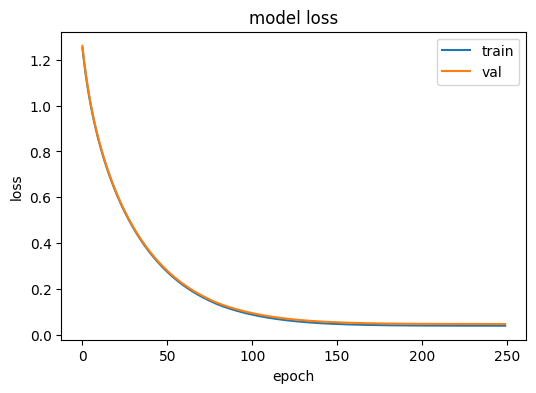

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_dec0.history['loss'])
plt.plot(history_dec0.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
TOFN_dec0 = model_dec0.predict([M_Val_dec0[:,:,0],M_Val_dec0[:,:,1]])

print(np.mean(TOFN_dec0))
print(np.std(TOFN_dec0))

5/5 [==============================] - 0s 916us/step
-3.8079624e-09
9.593204e-08


In [ ]:
t_shift = 8
V55_fraction_dec0 = np.zeros_like(V55_fraction)

for i in range(new_V55.shape[0]):
  noise_V55 = np.random.normal(scale=1e-3, size=t_shift)
  V55_fraction_dec0[i,:,0] = V55_fraction[i,:,0]
  V55_fraction_dec0[i,:,1] = np.roll(V55_fraction[i,:,0], t_shift)
  V55_fraction_dec0[i,0:t_shift,1] = noise_V55

M_V55_dec0 = momentos(V55_fraction_dec0)
M_V55_dec0_norm = (M_V55_dec0 - min_dec0)/(max_dec0-min_dec0)
TOFN_dec0_V55 = model_dec0.predict([M_V55_dec0_norm[:,:,0],M_V55_dec0_norm[:,:,1]])

print(np.mean(TOFN_dec0_V55))
print(np.std(TOFN_dec0_V55))

9/9 [==============================] - 0s 417us/step
6.7812536e-08
1.6362453e-08


CENTROID=  0.0007843137136660516
SIGMA =  0.0
FWHM (ns)=  0.0


/tmp/ipykernel_2518645/1054039308.py:4: RuntimeWarning: divide by zero encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
/tmp/ipykernel_2518645/1054039308.py:4: RuntimeWarning: invalid value encountered in divide
  return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))


Text(0.5, 0, 'Tiempo (ns)')

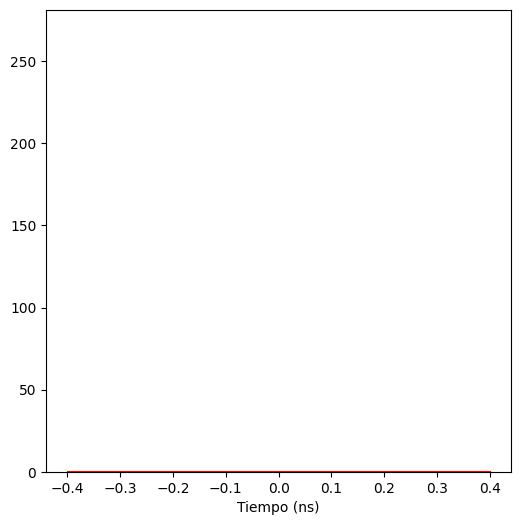

In [ ]:
plt.figure(figsize=(6,6))
nbins=510
histogN, binsN, patchesN  = plt.hist(TOFN_dec0_V55,bins=nbins,range=[-0.4,0.4],alpha=0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])



HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)
FWHMN = 2.35482 * sigmaN
plt.plot(cbinsN,gauss(cbinsN, HN, AN, x0N, sigmaN),'r-')
print("CENTROID= ",x0N)
print("SIGMA = ",sigmaN)
print("FWHM (ns)= ",FWHMN)


plt.xlabel('Tiempo (ns)')

# **DETECTOR 1**

## DATA CREATION


In [ ]:
INPUT2_dec1 = np.zeros_like(INPUT)
REF_dec1 = np.zeros((Ncasos,),dtype=np.float32)

NRD0 = np.random.randint(20, size=Ncasos)
NRD1 = np.random.randint(20, size=Ncasos)

for i in range(Ncasos):
  N0 = NRD0[i]
  noise0 = np.random.normal(scale=1e-3, size=N0)
  noise00 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise00, sigma=10)
  INPUT2_dec1[i,:,0]=np.roll(INPUT[i,:,1],N0)
  INPUT2_dec1[i,:,0] = INPUT2_dec1[i,:,0] + smoothed_noise
  INPUT2_dec1[i,0:N0,0] = INPUT[i,0:N0,1] + noise0

  N1 = NRD1[i]
  noise1 = np.random.normal(scale=1e-3, size=N1)
  noise11 = np.random.normal(scale=0.01, size=INPUT.shape[1])
  smoothed_noise = gaussian_filter1d(noise11, sigma=10)
  INPUT2_dec1[i,:,1]=np.roll(INPUT[i,:,1],N1)
  INPUT2_dec1[i,:,1] = INPUT2_dec1[i,:,1] + smoothed_noise
  INPUT2_dec1[i,0:N1,1] = INPUT[i,0:N1,1] + noise1

  REF_dec1[i]=new_time_step*(N0-N1)  #in ns (t_shift is defined above)


trainX_dec1 = INPUT2_dec1[0:Ntrain,:,:]
valX_dec1 = INPUT2_dec1[Ntrain:,:,:]

REF_train_dec1 = REF_dec1[0:Ntrain]
REF_val_dec1 = REF_dec1[Ntrain:]

In [ ]:
#-------------------------------------------------------------- Calculate moments ---------------------------------------------------
M_Train_dec1 = momentos(trainX_dec1)
M_Val_dec1 = momentos(valX_dec1)

min_dec1 = np.min(M_Train_dec1)
max_dec1 = np.max(M_Train_dec1)

M_Train_dec1 = (M_Train_dec1-min_dec1)/(max_dec1 - min_dec1)
M_Val_dec1 = (M_Val_dec1-min_dec1)/(max_dec1 - min_dec1)

NM = np.shape(M_Train_dec1)[1]

print(M_Train_dec1.shape,M_Val_dec1.shape, "NM =", NM)

(588, 12, 2) (148, 12, 2) NM = 12


## NEURAL NETWORK

In [ ]:
#------------------------------------------------------------- Initialize Model --------------------------------------------------------------------------------------
inputA = Input(shape=(NM,),)
inputB = Input(shape=(NM,))

x1 = Dense(4, activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1),kernel_regularizer=l2(0.01))
x2 = Dense(4, activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1),kernel_regularizer=l2(0.01))
x3 = Dense(4, activation='relu',kernel_initializer=initializers.RandomNormal(mean=0,stddev=1),kernel_regularizer=l2(0.01))
x4 = Dense(1, activation="linear")

op1A = x1(inputA)
op2A = x2(op1A)
op3A = x3(op2A)
outA = x4(op3A)

op1B = x1(inputB)
op2B = x2(op1B)
op3B = x3(op2B)
outB = x4(op3B)


model_dec1 = Model(inputs=[inputA, inputB], outputs= outA-outB)

In [ ]:
opt = tf.keras.optimizers.AdamW(learning_rate=1e-3)
model_dec1.compile(optimizer=opt, loss = 'MSE')
model_dec1.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_113 (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 input_114 (InputLayer)      [(None, 12)]                 0         []                            
                                                                                                  
 dense_256 (Dense)           (None, 4)                    52        ['input_113[0][0]',           
                                                                     'input_114[0][0]']           
                                                                                                  
 dense_257 (Dense)           (None, 4)                    20        ['dense_256[0][0]',    

In [ ]:
history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]], y = REF_train_dec1, validation_data=([M_Val_dec1[:,:,0],M_Val_dec1[:,:,1]],REF_val_dec1),epochs=250, batch_size=32,shuffle=True,verbose=1)

Epoch 1/250
19/19 [==============================] - 0s 4ms/step - loss: 0.6278 - val_loss: 0.6188
Epoch 2/250
19/19 [==============================] - 0s 1ms/step - loss: 0.6046 - val_loss: 0.5976
Epoch 3/250
19/19 [==============================] - 0s 1ms/step - loss: 0.5831 - val_loss: 0.5773
Epoch 4/250
19/19 [==============================] - 0s 1ms/step - loss: 0.5626 - val_loss: 0.5574
Epoch 5/250
19/19 [==============================] - 0s 1ms/step - loss: 0.5427 - val_loss: 0.5371
Epoch 6/250
19/19 [==============================] - 0s 1ms/step - loss: 0.5232 - val_loss: 0.5186
Epoch 7/250
19/19 [==============================] - 0s 1ms/step - loss: 0.5030 - val_loss: 0.5014
Epoch 8/250
19/19 [==============================] - 0s 1ms/step - loss: 0.4838 - val_loss: 0.4837
Epoch 9/250
19/19 [==============================] - 0s 1ms/step - loss: 0.4671 - val_loss: 0.4670
Epoch 10/250
19/19 [==============================] - 0s 1ms/step - loss: 0.4517 - val_loss: 0.4512
Epoch 11/

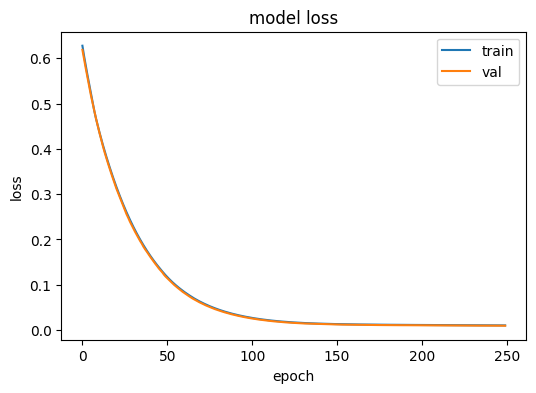

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history_dec1.history['loss'])
plt.plot(history_dec1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
TOFN_dec1 = model_dec1.predict([M_Val_dec1[:,:,0],M_Val_dec1[:,:,1]])

print(np.mean(TOFN_dec1))
print(np.std(TOFN_dec1))

5/5 [==============================] - 0s 509us/step
-0.04034158
0.1973699


In [ ]:
t_shift = 8
V55_fraction_dec1 = np.zeros_like(V55_fraction)


for i in range(V55_fraction.shape[0]):
  noise_V55 = np.random.normal(scale=1e-3, size=t_shift)
  V55_fraction_dec1[i,:,0] = V55_fraction[i,:,1]
  V55_fraction_dec1[i,:,1] = np.roll(V55_fraction[i,:,1], t_shift)
  V55_fraction_dec1[i,0:t_shift,1] = noise_V55

M_V55_dec1 = momentos(V55_fraction_dec1)
M_V55_dec1_norm = (M_V55_dec1 - min_dec1)/(max_dec1-min_dec1)
TOFN_dec1_V55 = model_dec1.predict([M_V55_dec1_norm[:,:,0],M_V55_dec1_norm[:,:,1]])

print(np.mean(TOFN_dec1_V55))
print(np.std(TOFN_dec1_V55))

9/9 [==============================] - 0s 746us/step
-0.16220659
0.02466454


CENTROID=  -0.17724631144489705
SIGMA =  0.007881498719980352
FWHM (ns)=  0.018559510815784133


Text(0.5, 0, 'Tiempo (ns)')

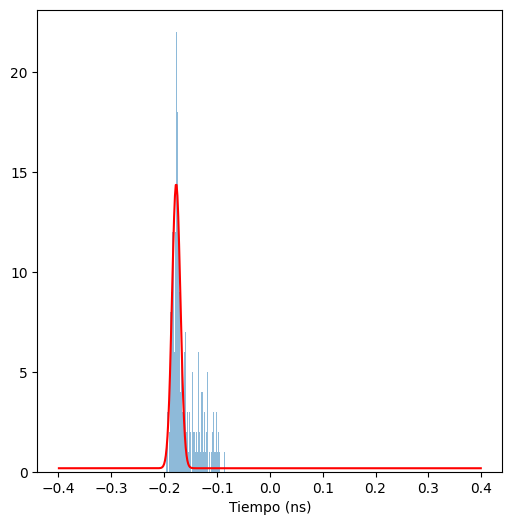

In [ ]:
plt.figure(figsize=(6,6))
nbins=510
histogN, binsN, patchesN  = plt.hist(TOFN_dec1_V55,bins=nbins,range=[-0.4,0.4],alpha=0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])


HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)
FWHMN = 2.35482 * sigmaN
plt.plot(cbinsN,gauss(cbinsN, HN, AN, x0N, sigmaN),'r-')
print("CENTROID= ",x0N)
print("SIGMA = ",sigmaN)
print("FWHM (ns)= ",FWHMN)


plt.xlabel('Tiempo (ns)')

# **FULL TOF**

In [ ]:
REFERENCE_PULSE_dec0 = np.tile(V82_fraction[0,:,0], (V82_fraction.shape[0],2,1)).swapaxes(1,2)
REFERENCE_PULSE_dec1 = np.tile(V82_fraction[0,:,1], (V82_fraction.shape[0],2,1)).swapaxes(1,2)


M_REF_dec0 = momentos(REFERENCE_PULSE_dec0)
M_REF_dec0 = (M_REF_dec0 - min_dec0)/(max_dec0-min_dec0)

M_REF_dec1 = momentos(REFERENCE_PULSE_dec1)
M_REF_dec1 = (M_REF_dec1 - min_dec1)/(max_dec1-min_dec1)

M_V28 = momentos(V28_fraction)
M_V28_norm = np.zeros_like(M_V28)
M_V28_norm[:,:,0] = (M_V28[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V28_norm[:,:,1] = (M_V28[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V28.shape)

M_V55 = momentos(V55_fraction)
M_V55_norm = np.zeros_like(M_V55)
M_V55_norm[:,:,0] = (M_V55[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V55_norm[:,:,1] = (M_V55[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V55.shape)

M_V82 = momentos(V82_fraction)
M_V82_norm = np.zeros_like(M_V82)
M_V82_norm[:,:,0] = (M_V82[:,:,0] - min_dec0) / (max_dec0 - min_dec0)
M_V82_norm[:,:,1] = (M_V82[:,:,1] - min_dec1) / (max_dec1 - min_dec1)
print(M_V82.shape)

(187, 12, 2)
(268, 12, 2)
(281, 12, 2)


6/6 [==============================] - 0s 478us/step

V82: CENTROID(ns) = 0.460  FWHM(ns) = 0.431  std(ns) = 0.183
V55: CENTROID(ns) = 0.039  FWHM(ns) = 0.637  std(ns) = 0.270
V28: CENTROID(ns) = 0.182  FWHM(ns) = 0.658  std(ns) = 0.280


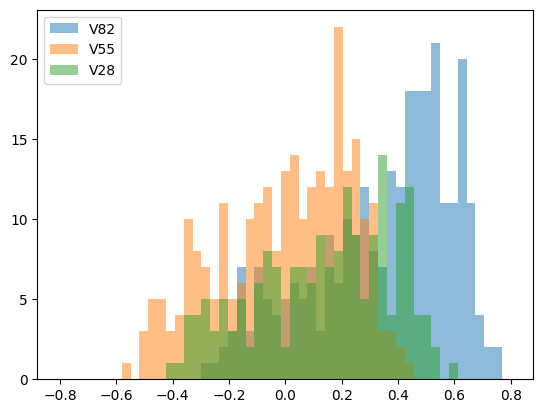

In [ ]:
TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])
TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])


TOFN_V82 = TOFN_dec0_REF_V82 - TOFN_dec1_REF_V82
TOFN_V55 = TOFN_dec0_REF_V55 - TOFN_dec1_REF_V55
TOFN_V28 = TOFN_dec0_REF_V28 - TOFN_dec1_REF_V28


#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*TOFN_V82 + np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*TOFN_V55 + np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*TOFN_V28 + np.mean(TOFN_V55),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

19/19 [==============================] - 0s 289us/step
0.20119502
0.03405176
0.20526816

CENTROID(ns) = -0.004  FWHM(ns) = 0.539  std(ns) = 0.229


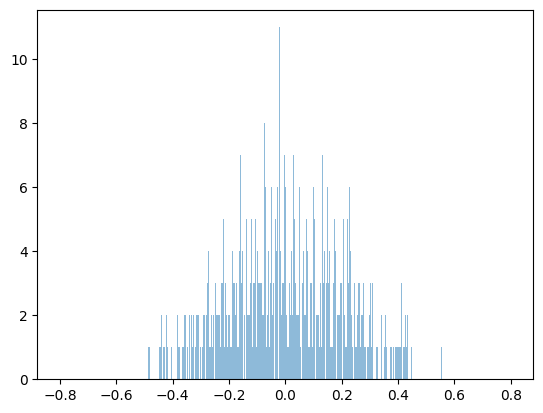

In [ ]:
TOFN_dec0 = np.squeeze(model_dec0.predict([M_Train_dec0[:,:,0],M_Train_dec0[:,:,1]])) - REF_train_dec0
TOFN_dec1 = np.squeeze(model_dec1.predict([M_Train_dec1[:,:,0],M_Train_dec1[:,:,1]])) - REF_train_dec1
print(np.std(TOFN_dec0))
print(np.std(TOFN_dec1))


TOFN = TOFN_dec0 - TOFN_dec1
print(np.std(TOFN))

nbins=510
histogN, binsN, patchesN  = plt.hist(TOFN,bins=nbins,range=[-0.8,0.8],alpha = 0.5);
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N, sigmaN = gauss_fit(cbinsN, histogN)

FWHMN = 2.35482 * sigmaN

print('')
print("CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N, FWHMN, sigmaN))


# **MULTIPLE TRAINING**

In [ ]:
def weights_definition(NM, Npoints):
  t = np.linspace(0,Npoints, Npoints)/float(Npoints) #Normalized array of time
  Weights = np.zeros((Npoints,NM))
  NMW = int(NM/3) #Number of Moments per weight

  for i in range(NMW):
    Weights[:,i] = t**(i+1)

  for i in range(NMW):
    Weights[:,i + NMW] = np.exp(-t**(i))

  for i in range(NMW):
    Weights[:,i + 2*(NMW)] = np.exp(-(i)*t)

  return Weights

In [ ]:
NM = 12
weights = weights_definition(NM,70)

In [ ]:
def model_definition(NM):

  inputA = Input(shape=(NM,))
  inputB = Input(shape=(NM,))

  x1 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5) , kernel_regularizer=l2(0.01))
  x2 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5) , kernel_regularizer=l2(0.01))
  x3 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=1.5) , kernel_regularizer=l2(0.01))
  x4 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  outA = x4(op3A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  outB = x4(op3B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

#---------------------------------------------------------------------------------------------------------------------------------------------

def model_definition_manual_weight_initialization(N_time_points):

  inputA = Input(shape=(N_time_points,))
  inputB = Input(shape=(N_time_points,))

  #x1 = Dense(NM, activation="relu", weights=[weights, np.zeros(NM)])
  x1 = Dense(NM, activation="relu",kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x2 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x3 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x4 = Dense(4, activation="relu", kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.5), kernel_regularizer=l2(0.01))
  x5 = Dense(1, activation="linear")

  op1A = x1(inputA)
  op2A = x2(op1A)
  op3A = x3(op2A)
  op4A = x4(op3A)
  outA = x5(op4A)

  op1B = x1(inputB)
  op2B = x2(op1B)
  op3B = x3(op2B)
  op4B = x4(op3B)
  outB = x5(op4B)

  model = Model(inputs=[inputA, inputB], outputs=outA-outB)
  return model

In [ ]:
Ntries= 10

TOFN_V28_list = []
TOFN_V55_list = []
TOFN_V82_list = []

for i in range(Ntries):

  model_dec0 = model_definition(NM)
  model_dec1 = model_definition(NM)

  #model_dec0 = model_definition_manual_weight_initialization(Nt_new)
  #model_dec1 = model_definition_manual_weight_initialization(Nt_new)

  opt_dec0 = tf.keras.optimizers.AdamW(learning_rate=7.0e-4)
  opt_dec1 = tf.keras.optimizers.AdamW(learning_rate=7.0e-4)

  model_dec0.compile(optimizer=opt_dec0,loss='MSE')
  model_dec1.compile(optimizer=opt_dec1,loss='MSE')

  history_dec0 = model_dec0.fit(x=[M_Train_dec0[:,:,0], M_Train_dec0[:,:,1]],y = REF_train_dec0,validation_data=([M_Val_dec0[:,:,0], M_Val_dec0[:,:,1]], REF_val_dec0), epochs=250, batch_size = 64, shuffle = True, verbose=0)
  history_dec1 = model_dec1.fit(x=[M_Train_dec1[:,:,0], M_Train_dec1[:,:,1]],y = REF_train_dec1,validation_data=([M_Val_dec1[:,:,0], M_Val_dec1[:,:,1]], REF_val_dec1), epochs=250, batch_size = 64, shuffle = True, verbose=0)

  #history_dec0 = model_dec0.fit(x=[trainX_dec0[:,:,0], trainX_dec0[:,:,1]],y = REF_train_dec0,validation_data=([valX_dec0[:,:,0], valX_dec0[:,:,1]], REF_val_dec0), epochs=250, batch_size = 64, shuffle = True, verbose=0)
  #history_dec1 = model_dec1.fit(x=[trainX_dec1[:,:,0], trainX_dec1[:,:,1]],y = REF_train_dec1,validation_data=([valX_dec1[:,:,0], valX_dec1[:,:,1]], REF_val_dec1), epochs=250, batch_size = 64, shuffle = True, verbose=0)

  TOFN_dec0_REF_V28 = model_dec0.predict([M_REF_dec0[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,0]])
  TOFN_dec0_REF_V55 = model_dec0.predict([M_REF_dec0[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,0]])
  TOFN_dec0_REF_V82 = model_dec0.predict([M_REF_dec0[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,0]])
  TOFN_dec1_REF_V28 = model_dec1.predict([M_REF_dec1[:M_V28_norm.shape[0],:,0],M_V28_norm[:,:,1]])
  TOFN_dec1_REF_V55 = model_dec1.predict([M_REF_dec1[:M_V55_norm.shape[0],:,0],M_V55_norm[:,:,1]])
  TOFN_dec1_REF_V82 = model_dec1.predict([M_REF_dec1[:M_V82_norm.shape[0],:,0],M_V82_norm[:,:,1]])

  #TOFN_dec0_REF_V82 = model_dec0.predict([REFERENCE_PULSE_dec0[:V82_fraction.shape[0],:,0],V82_fraction[:,:,0]])
  #TOFN_dec1_REF_V82 = model_dec1.predict([REFERENCE_PULSE_dec1[:V82_fraction.shape[0],:,0],V82_fraction[:,:,1]])
  #TOFN_dec0_REF_V55 = model_dec0.predict([REFERENCE_PULSE_dec0[:V55_fraction.shape[0],:,0],V55_fraction[:,:,0]])
  #TOFN_dec1_REF_V55 = model_dec1.predict([REFERENCE_PULSE_dec1[:V55_fraction.shape[0],:,0],V55_fraction[:,:,1]])
  #TOFN_dec0_REF_V28 = model_dec0.predict([REFERENCE_PULSE_dec0[:V28_fraction.shape[0],:,0],V28_fraction[:,:,0]])
  #TOFN_dec1_REF_V28 = model_dec1.predict([REFERENCE_PULSE_dec1[:V28_fraction.shape[0],:,0],V28_fraction[:,:,1]])

  TOFN_V82 = TOFN_dec0_REF_V82-TOFN_dec1_REF_V82
  TOFN_V55 = TOFN_dec0_REF_V55-TOFN_dec1_REF_V55
  TOFN_V28 = TOFN_dec0_REF_V28-TOFN_dec1_REF_V28

  TOFN_V28_list.append(TOFN_V28)
  TOFN_V55_list.append(TOFN_V55)
  TOFN_V82_list.append(TOFN_V82)

TOFN_V28_array = np.array(TOFN_V28_list, dtype = 'object')
TOFN_V55_array = np.array(TOFN_V55_list, dtype = 'object')
TOFN_V82_array = np.array(TOFN_V82_list, dtype = 'object')


In [ ]:
for i in range(TOFN_V28_array.shape[0]):
  centroid_V28 = -1*np.mean(TOFN_V28_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  centroid_V82 = -1*np.mean(TOFN_V82_array[i,:]) + np.mean(TOFN_V55_array[i,:])
  mean_error_centroid = (abs(centroid_V28 + 0.2) + abs(centroid_V82-0.2)) / 2
  mean_std = (np.std(TOFN_V82_array[i,:]) + np.std(TOFN_V55_array[i,:]) + np.std(TOFN_V28_array[i,:])) / 3

  epsilon = np.sqrt(mean_error_centroid**2 + mean_std**2)
  print('index: %d  %.3f %.3f %.3f' % (i, mean_std, mean_error_centroid,epsilon))

index: 0  0.084 0.010 0.085
index: 1  0.092 0.035 0.098
index: 2  0.081 0.013 0.082
index: 3  0.084 0.023 0.087
index: 4  0.096 0.039 0.104
index: 5  0.096 0.025 0.099
index: 6  0.085 0.024 0.088
index: 7  0.092 0.175 0.198
index: 8  0.088 0.030 0.093
index: 9  0.072 0.007 0.073



V82: CENTROID(ns) = 0.180  FWHM(ns) = 0.193  std(ns) = 0.078
V55: CENTROID(ns) = 0.002  FWHM(ns) = 0.164  std(ns) = 0.069
V28: CENTROID(ns) = -0.195  FWHM(ns) = 0.155  std(ns) = 0.071


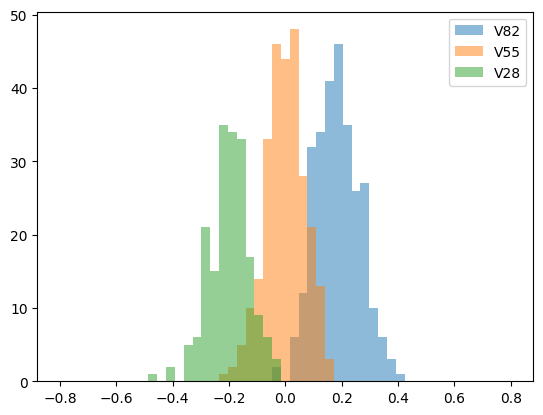

In [ ]:
index = 9
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
nbins=51
histogN_V82, binsN, patchesN  = plt.hist(-1*(TOFN_V82_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V82');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V82, sigmaN_V82 = gauss_fit(cbinsN, histogN_V82)

histogN_V55, binsN, patchesN  = plt.hist(-1*(TOFN_V55_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V55');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V55, sigmaN_V55 = gauss_fit(cbinsN, histogN_V55)

histogN_V28, binsN, patchesN  = plt.hist(-1*(TOFN_V28_array[index]) + np.mean(TOFN_V55_array[index]),bins=nbins,range=[-0.8,0.8],alpha = 0.5,label='V28');
cbinsN = 0.5*(binsN[1:]+binsN[0:-1])
HN, AN, x0N_V28, sigmaN_V28 = gauss_fit(cbinsN, histogN_V28)
plt.legend()


FWHMN_V82 = 2.35482 * sigmaN_V82
FWHMN_V55 = 2.35482 * sigmaN_V55
FWHMN_V28 = 2.35482 * sigmaN_V28


print('')
print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, np.std(TOFN_V82)))
print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, np.std(TOFN_V55)))
print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, np.std(TOFN_V28)))

# **SAVE MODELS**

In [ ]:
#from tensorflow.keras.models import save_model
#model_dec0.save('/home/josea/PET_CABEZA/timing/model_dec0_28_02_2024_ONLY_REALS.h5')
#model_dec1.save('/home/josea/PET_CABEZA/timing/model_dec1_28_02_2024_ONLY_REALS.h5')